### Задача uplift-моделирования

### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### Практический пример с соревнования X5 

http://retailhero.ai/#rec141268104

Импортируем нужные библиотеки и предобработаем данные:

In [ ]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

## Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/ML в бизнесе/Lesson4/'

In [ ]:
df = pd.read_csv(path + 'HW_data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


### 2. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [ ]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)

In [ ]:
df['treatment'] = df['treatment'].apply(lambda x: 0 if x == 'No Offer' else 1)

In [ ]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [ ]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [ ]:
df.groupby("treatment")['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,21306.0,0.106167,0.308059,0.0,0.0,0.0,0.0,1.0
1,42694.0,0.167049,0.373024,0.0,0.0,0.0,0.0,1.0


Заведем переменные

In [ ]:
indices_learn, indices_valid = train_test_split(df, test_size=0.3, random_state=123)


X_train = indices_learn.copy()
X_train = X_train.drop(columns = ['target', 'treatment'])
y_train = indices_learn['target'].copy()
treat_train = indices_learn['treatment'].copy()

X_val = indices_valid.copy()
X_val = X_val.drop(columns = ['target', 'treatment'])
y_val = indices_valid['target'].copy()
treat_val = indices_valid['treatment'].copy()


In [ ]:
cat_features = ['zip_code', 'channel']
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

### 1. Подходы с одной моделью
#### 1.1 Одна модель с признаком коммуникации
Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

In [ ]:
# !pip install scikit-uplift catboost

In [ ]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


# SoloModel

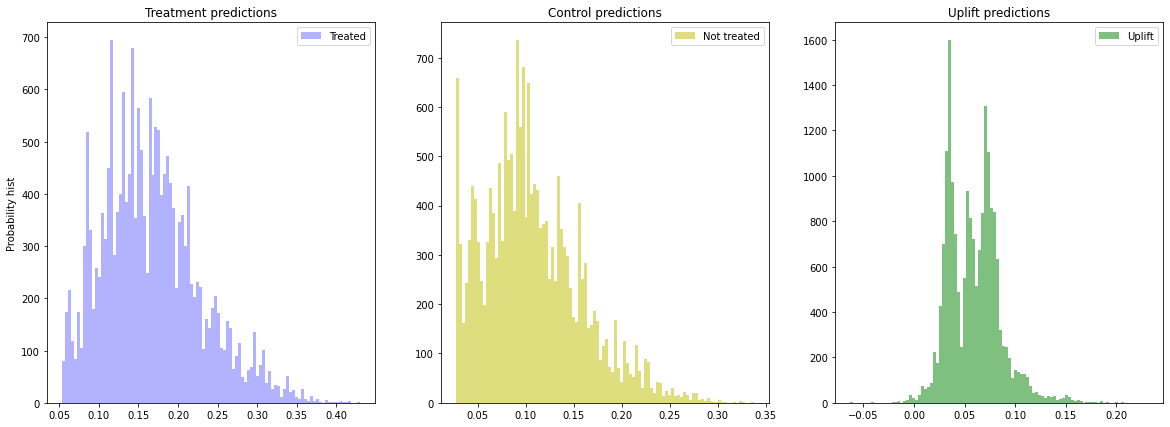

In [ ]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [ ]:
from sklift.viz import plot_uplift_curve

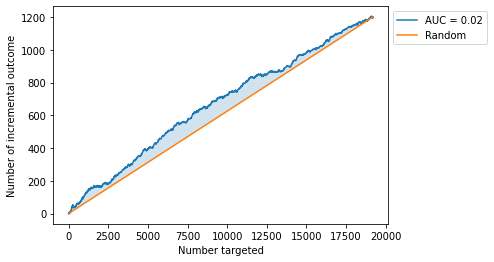

In [ ]:
plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=False)

Посмотрим на топ-признаки

In [ ]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,19.189426
1,treatment,17.927079
2,used_bogo,12.651803
3,recency,11.793690
4,channel,11.197806
5,zip_code,9.776886
6,used_discount,8.943366
7,history,8.519945


In [ ]:
n = 15
data = pd.DataFrame({'true': y_val, 'uplift': uplift_sm, 'treat': treat_val})
data

,true,uplift,treat
19593,1,0.022362,1
4997,0,-0.001955,0
36682,0,0.025087,0
29881,0,0.043634,1
25401,0,0.034606,1
...,...,...,...
39655,0,0.034364,1
45479,0,0.047622,0
21007,0,0.063032,1
39923,0,0.118862,1


In [ ]:
k=0.7
uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='overall', k=k)

0.06481923015551162

In [ ]:
df_k = data.sort_values(by='uplift', ascending=False).head(int(len(data)*k))

In [ ]:
responce_rate_treat = df_k[(df_k['treat'] == 1)].true.mean()
responce_rate_control = df_k[(df_k['treat'] == 0)].true.mean()
responce_rate_treat - responce_rate_control

0.06486461272292651

In [ ]:
from sklift.metrics import uplift_by_percentile

In [ ]:
uplift_by_percentile(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='overall', total=True, std=True, bins=10)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1306,614,0.242726,0.157980,0.084745,0.011864,0.014719,0.018905
10-20,1275,645,0.206275,0.141085,0.065189,0.011332,0.013707,0.017784
20-30,1280,640,0.178125,0.090625,0.087500,0.010694,0.011348,0.015593
30-40,1274,646,0.166405,0.103715,0.062690,0.010435,0.011996,0.015899
40-50,1278,642,0.151800,0.084112,0.067688,0.010037,0.010954,0.014857
50-60,1292,628,0.151703,0.087580,0.064123,0.009980,0.011280,0.015062
60-70,1258,662,0.152623,0.132931,0.019693,0.010139,0.013195,0.016641
70-80,1276,644,0.144984,0.079193,0.065792,0.009856,0.010641,0.014505
80-90,1271,649,0.133753,0.073960,0.059793,0.009548,0.010273,0.014025


In [ ]:
from sklift.viz import plot_uplift_by_percentile

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb88aa34790>,
      dtype=object)

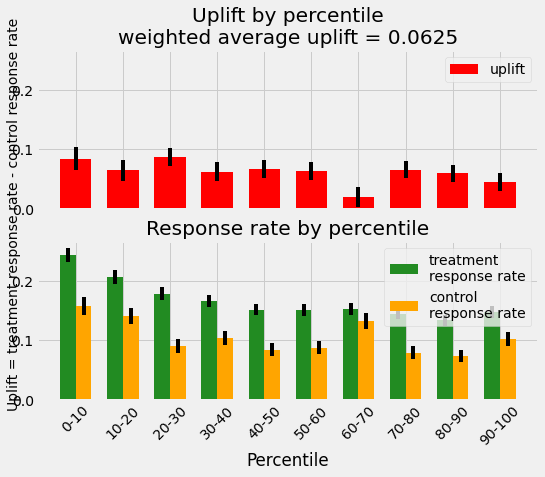

In [ ]:
plot_uplift_by_percentile(y_val, uplift_sm, treat_val, strategy='overall', kind = 'bar')

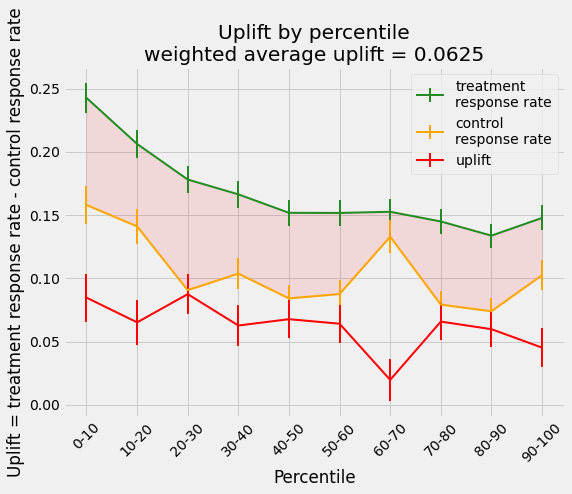

In [ ]:
plot_uplift_by_percentile(y_val, uplift_sm, treat_val, strategy='overall', kind = 'line')

Начиная с 60-го перцентиля по-моему не стоит беспокоить клиентов. Или модель не очень четко сортирует клиентов?

## 1.2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

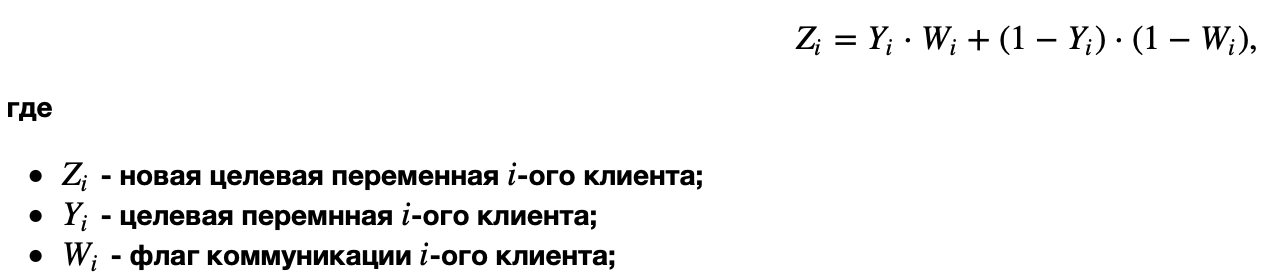![ab_split](uplift5.png "uplift5")

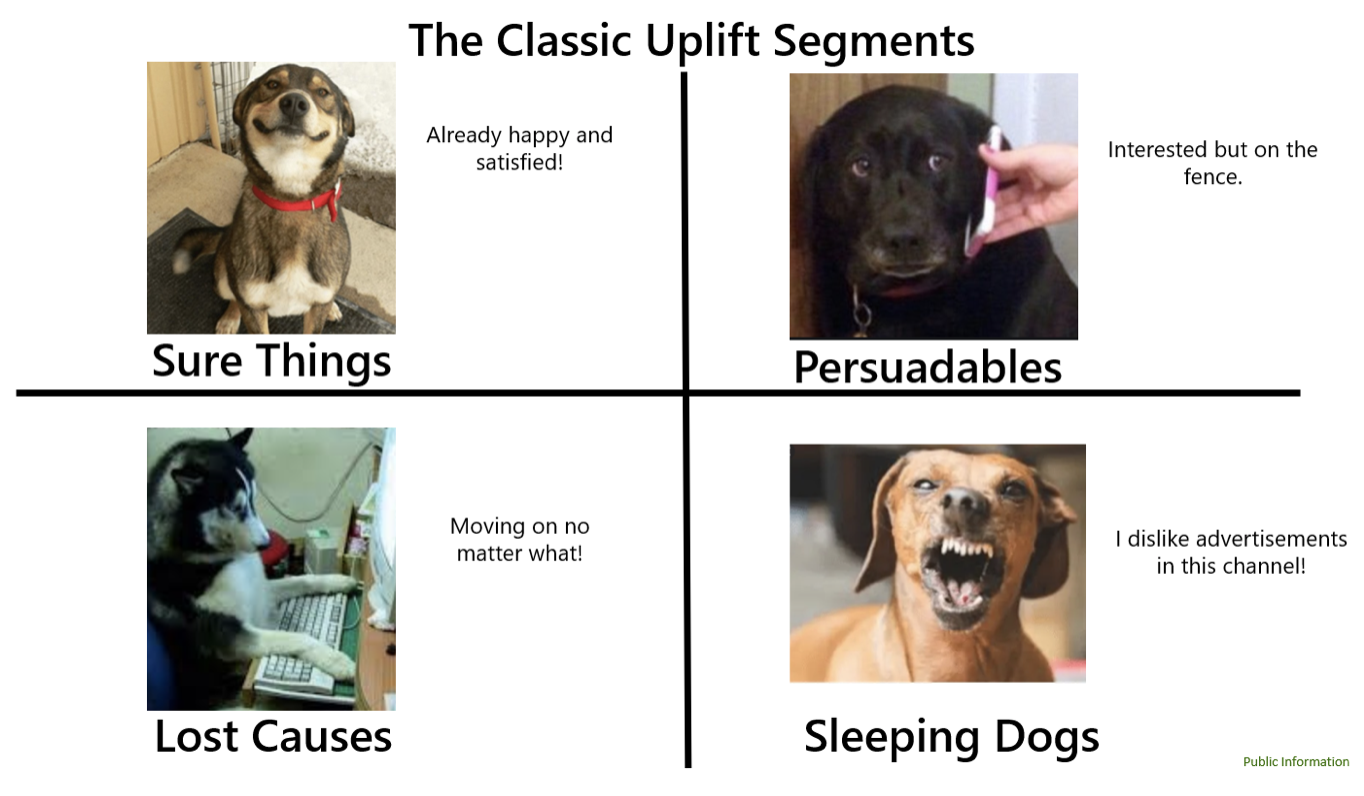![ab_split](uplift_client_types.png "uplift_client_types")

In [ ]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)


models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

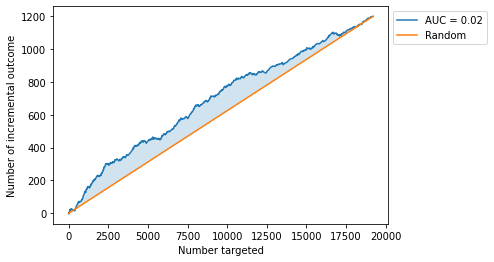

In [ ]:
plot_uplift_curve(y_val, uplift_ct, treat_val, perfect=False)

## Две независимые модели

Другие названия: Two models approach, T-learner, difference two models

Интуитивно понятный и простой метод - моделируем 2 условные вероятности

1. обучаем модель прогноза вероятности совершения целевого действия для контрольной группы
2. обучаем модель прогноза вероятности совершения целевого действия для экспериментальной группы
3. на прогнозе - делаем прогноз для тестовых пользователей двумя моделями и вычитаем из прогноза второй модели прогноз первой

подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

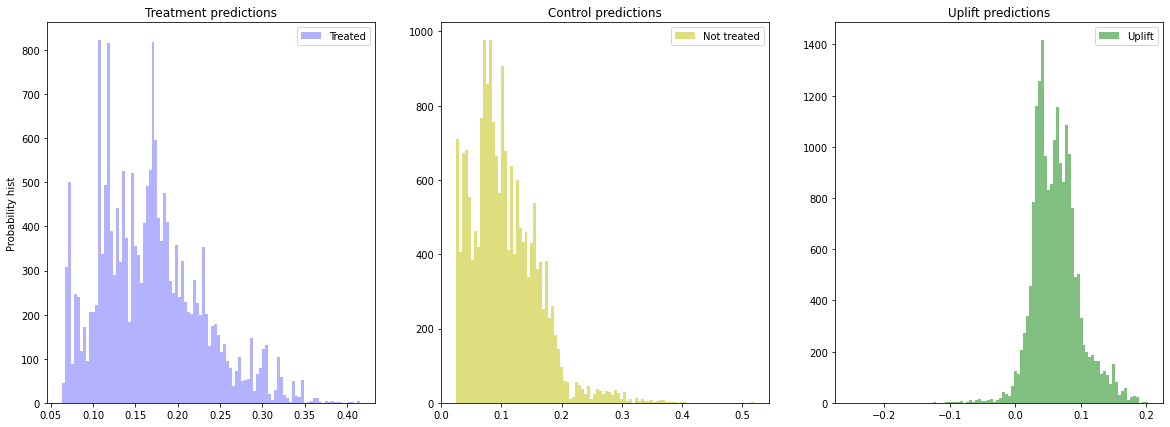

In [ ]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)


models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

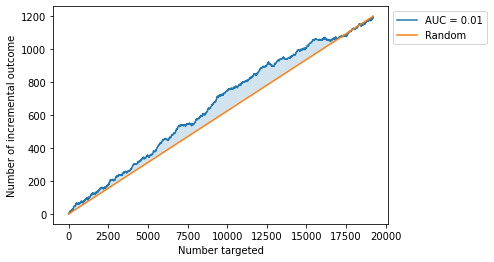

In [ ]:
plot_uplift_curve(y_val, uplift_tm, treat_val, perfect=False)

###  Посмотрим на результаты работы 3-х моделей

In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.117411,0.095800
0,SoloModel,0.089254,0.078994
2,TwoModels,0.078306,0.068439


Лучший результат показала модель с трансформацией классов

## UpliftTreeClassifier

In [ ]:
# !pip install causalml

#### Вариант с деревом решений

In [ ]:
indices_learn, indices_valid = train_test_split(df, test_size=0.3, random_state=123)


X_train = indices_learn.copy()
X_train = X_train.drop(columns = ['target', 'treatment'])
y_train = indices_learn['target'].copy()
treat_train = indices_learn['treatment'].copy()

X_val = indices_valid.copy()
X_val = X_val.drop(columns = ['target', 'treatment'])
y_val = indices_valid['target'].copy()
treat_val = indices_valid['treatment'].copy()

In [ ]:
X_train_tree = pd.concat([X_train.drop('zip_code', 1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code')], 1)
X_train_tree = pd.concat([X_train_tree.drop('channel', 1), 
                          pd.get_dummies(X_train['channel'], prefix='channel')], 1)
features = [col for col in X_train_tree]

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [ ]:
X_val_tree = pd.concat([X_val.drop('zip_code', 1), 
                          pd.get_dummies(X_val['zip_code'], prefix='zip_code')], 1)
X_val_tree = pd.concat([X_val_tree.drop('channel', 1), 
                          pd.get_dummies(X_val['channel'], prefix='channel')], 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [ ]:
X_train_tree

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
53181,8,121.56,0,1,0,0,1,0,0,0,1
42635,9,617.62,0,1,1,0,0,1,0,1,0
6296,5,185.62,1,0,1,1,0,0,0,0,1
41722,1,359.03,0,1,0,1,0,0,0,0,1
32660,10,139.68,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
61404,1,172.98,1,0,0,0,1,0,0,0,1
17730,9,95.41,0,1,0,0,1,0,0,1,0
28030,1,547.69,1,1,1,1,0,0,1,0,0
15725,5,341.39,0,1,0,0,1,0,0,1,0


ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


CPU times: user 3.11 s, sys: 537 ms, total: 3.65 s
Wall time: 7.56 s


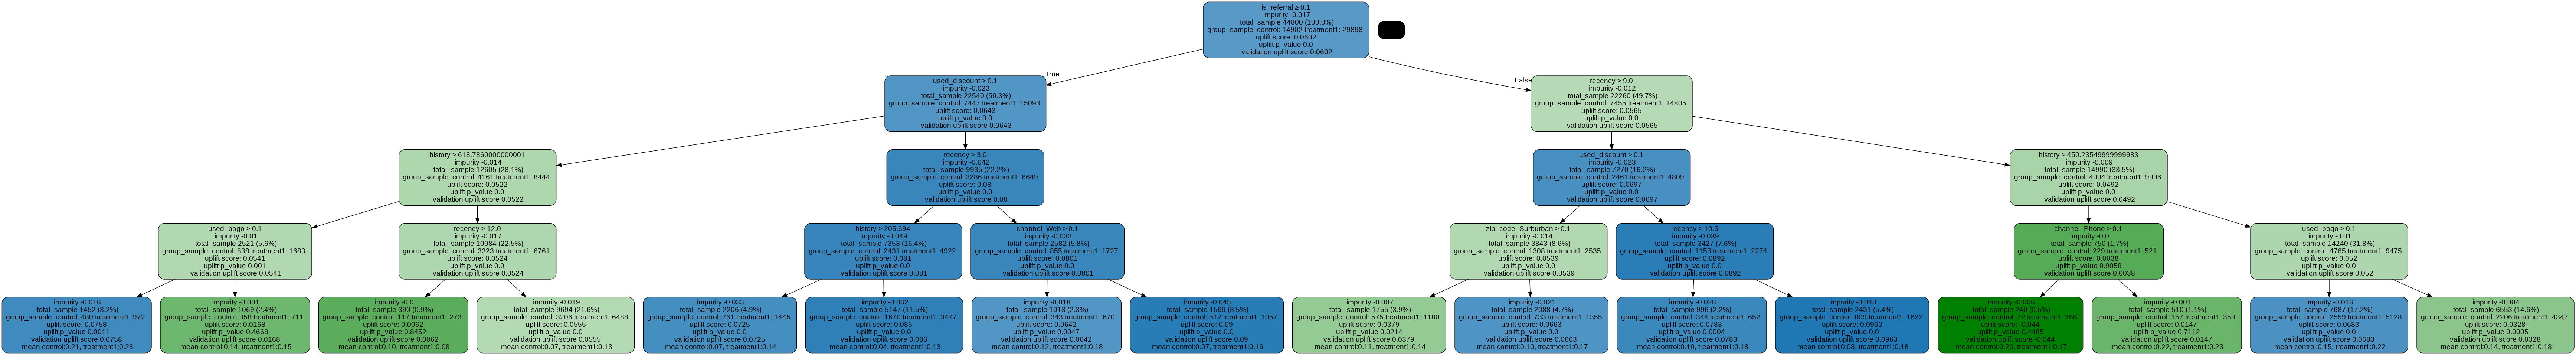

In [ ]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

По дереву решений можно увидеть по каким признакам (и при каках значениях) лучше выбирать клиентов для совершения звонка (высокое значение uplift score, малое значение p_value, а каких клиентов лучше не беспокоить. Об этом скажет отрицательное значение uplift score. Высокое значение p_value означает, что результаты могут считаться статистически значимыми. Это может быть связано с размером выборки, разбросом данных?

In [ ]:
# Print uplift tree as a string
result = uplift_tree_string(uplift_model.fitted_uplift_tree, X_train_tree.columns)

is_referraltreatment_group_key >= 0.1?
yes -> used_discounttreatment_group_key >= 0.1?
		yes -> historytreatment_group_key >= 618.7860000000001?
				yes -> used_bogotreatment_group_key >= 0.1?
						yes -> [0.20833333333333334, 0.2829218106995885]
						no  -> [0.13687150837988826, 0.1518987341772152]
				no  -> recencytreatment_group_key >= 12.0?
						yes -> [0.10256410256410256, 0.08424908424908426]
						no  -> [0.07205240174672489, 0.12762022194821207]
		no  -> recencytreatment_group_key >= 3.0?
				yes -> historytreatment_group_key >= 205.694?
						yes -> [0.06964520367936924, 0.14048442906574393]
						no  -> [0.03952095808383234, 0.12597066436583262]
				no  -> channel_Webtreatment_group_key >= 0.1?
						yes -> [0.12244897959183673, 0.18059701492537314]
						no  -> [0.072265625, 0.16461684011352887]
no  -> recencytreatment_group_key >= 9.0?
		yes -> used_discounttreatment_group_key >= 0.1?
				yes -> zip_code_Surburbantreatment_group_key >= 0.1?
						yes -> [0.1078260869565

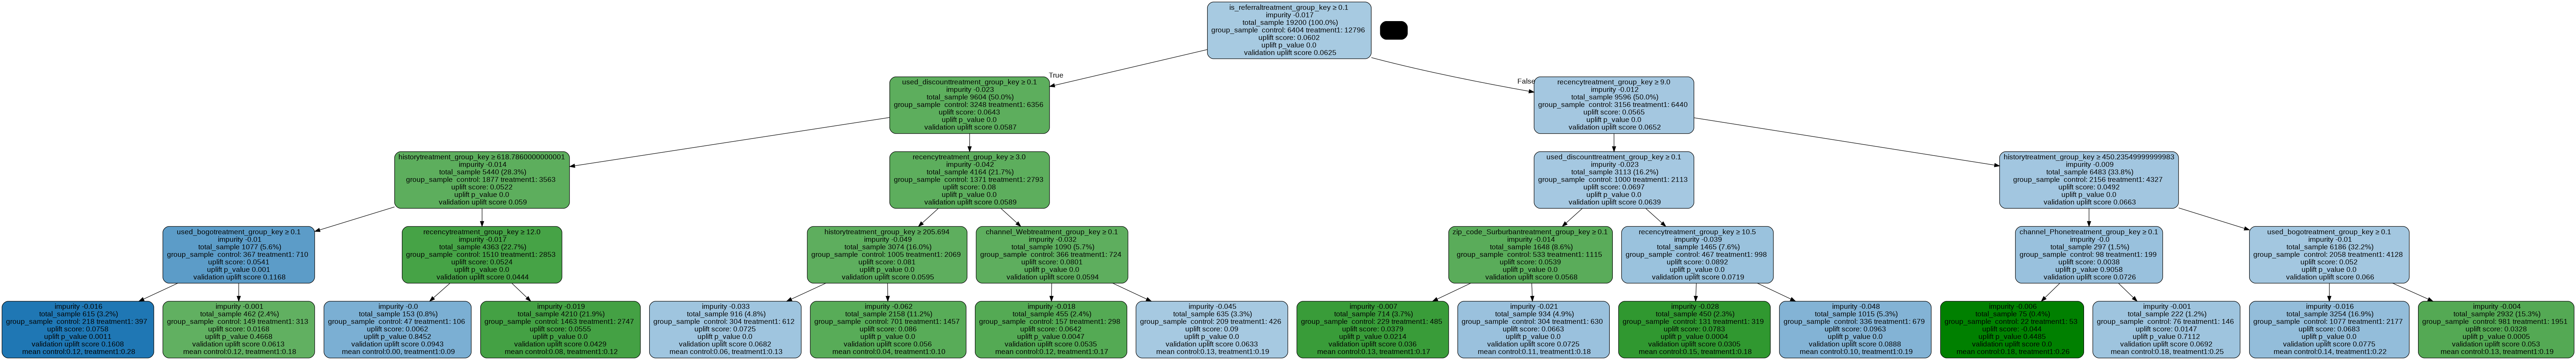

In [ ]:
### Построим дерево на валидационных данных 
# The uplift score based on testing dataset is shown as validation uplift score in the tree nodes
uplift_model.fill(X=X_val_tree.values, treatment=treat_val.map({1: 'treatment1', 0: 'control'}).values, y=y_val.values)

# Plot uplift tree
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, X_train_tree.columns)
Image(graph.create_png())

In [ ]:
y_pred = uplift_model.predict(X=X_val_tree.values)

### Ссылки

1. https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0
2. https://habr.com/ru/company/ru_mts/blog/485980/#reference1
3. https://en.wikipedia.org/wiki/Uplift_modelling
4. https://www.youtube.com/watch?v=yFQAIJBYXI0
5. https://www.youtube.com/watch?v=jCUcYiBK03I
6. https://www.uplift-modeling.com/en/latest/
7. https://arxiv.org/pdf/1809.04559.pdf
8. https://catboost.ai/docs/concepts/about.html

### Библиотеки и пакеты

1. causalml
2. sklift
3. catboost